/tmp/ipykernel_29277/2498354263.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns = ["class"], axis = 1, inplace = True)
/home/thillers/miniconda3/envs/XGBIgor/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/thillers/miniconda3/envs/XGBIgor/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/thillers/miniconda3/envs/XGBIgor/lib/python3.9/site-packages/xgboost/core.py:91: UserWarning: ntree_limit is depreca

successfully saved test dataframe for 2tau
job done


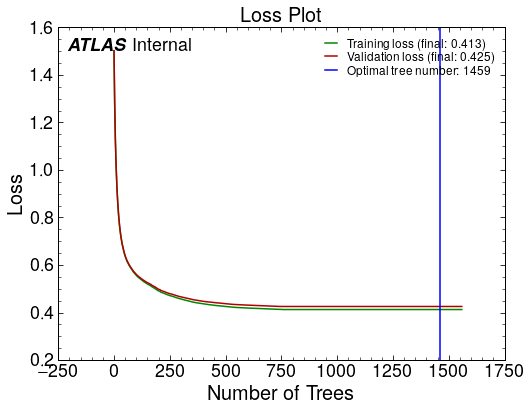

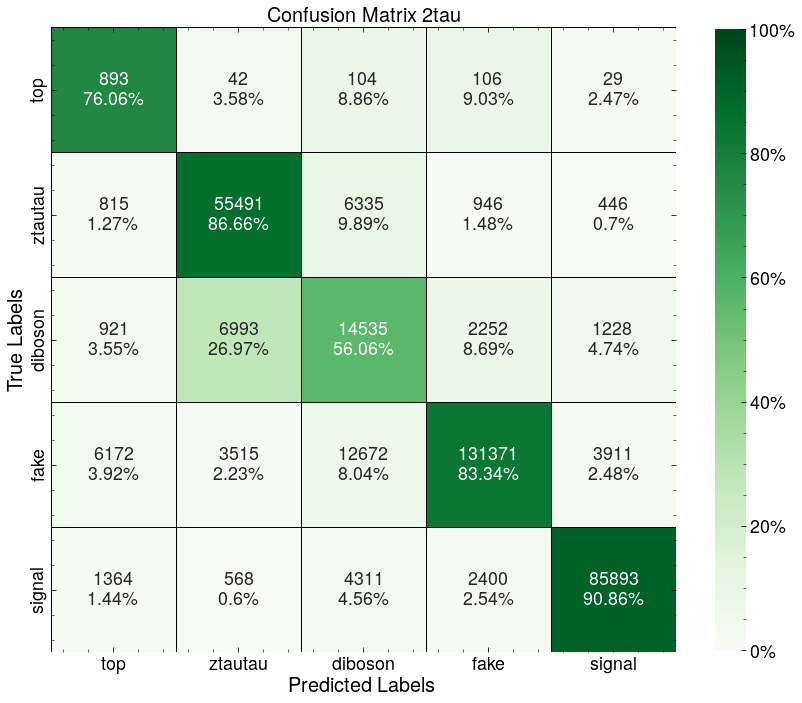

In [9]:
#Standard train-test BDT
#External imports
import json 
import awkward as ak
import numpy as np
import pandas as pd
import atlas_mpl_style as ampl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import xgboost as xgb
import pickle
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import RepeatedStratifiedKFold
import os, sys
from pathlib import Path

#Config matplotlib with ATLAS and LaTeX
os.environ['PATH'] += '/cvmfs/sft.cern.ch/lcg/external/texlive/2020/bin/x86_64-linux'
plt.rc('text', usetex=True)             # Matplotlib LaTeX Compatibility
ampl.use_atlas_style(usetex=True)       # ATLAS Style

#Config path
sys.path.append(str(Path(os.getcwd()).parent) + '/Scripts/Definers/')
from PathsDefiner import paths_definer
path_pickles = paths_definer()

#Local imports
from LoadVariables import trainingVariables
from TrainTestSplitter import split_data
from ResultsPresenter import results_presenter
from LossPlotter import loss_plotter
from ConfusionMatrixPlotter import confusion_matrix_plotter
from InsertPredictions import insert_preds

test_size = 0.2
split = "train_test"
#Training parameters
n_trees = 50000
learning_rate = 0.1
depth = 5
gamma = 0.1
reg_lambda = 0

channels = ["2tau"]

for channel in channels:

    path = f"/disk/atlas3/users/thillers/tauX/R25.2.8/pickles/Run2/{channel}/dataframe.pkl"
    with open(path, "rb") as infile:
        df = pickle.load(infile)

    df = df[df["class"] != 10] #Remove other class from training

    df = df.sample(frac = 1).reset_index(drop = True)
    n_minority = df["class"].value_counts().min()
    class_weights = n_minority / df["class"].value_counts()
    df["class_weight"] = df["class"].map(class_weights)

    BDT_inputs = trainingVariables(channel = channel)
    df = df.sample(frac = 1).reset_index(drop = True) #for good measure, shuffles class weight and run info
    df_train = df[BDT_inputs]
    df = df.drop(columns = BDT_inputs)

    y = df_train["class"]
    X = df_train
    X.drop(columns = ["class"], axis = 1, inplace = True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = test_size, shuffle = False)
    X_train_class_weight = X_train.class_weight
    X_train.drop(columns = ["class_weight"], axis = 1, inplace = True)
    X_test.drop(columns = ["class_weight"], axis = 1, inplace = True)

    outpath = f"/disk/atlas3/users/thillers/tauX/R25.2.8/machine_learning/train_test/{channel}/"
    os.makedirs(outpath, exist_ok = True)
    
    hyperparameters = {
        'booster':'gbtree',
        'n_estimators':n_trees,      
        'learning_rate': learning_rate,     
        'max_depth': depth,                     
        'min_child_weight':1,                  
        'gamma':gamma,                          
        'subsample':1.0,                      
        'colsample_bytree':1.0,             
        'reg_alpha':0,                        
        'reg_lambda':reg_lambda,                              
        'max_delta_step':0,               
        'objective':"multi:softproba",               
        'tree_method':'gpu_hist',            
        'gpu_id':0,                          
        'predictor':'gpu_predictor',
        'seed':1,                            
        'num_class':len(np.unique(y_test))          
    }

    fit_parameters = {
        'X': X_train,
        'y': y_train,
        "sample_weight" : X_train_class_weight,
        'eval_set': [(X_train, y_train), (X_test, y_test)],
        'eval_metric': "mlogloss",
        'early_stopping_rounds': 100,
        'verbose': 0
    }

    xgb_model = xgb.XGBClassifier(**hyperparameters)
    xgb_model.fit(X_train, y_train, **fit_parameters)
    predictions = xgb_model.predict(X_test, ntree_limit = xgb_model.best_ntree_limit)
    predictions_proba = xgb_model.predict_proba(X_test, ntree_limit = xgb_model.best_ntree_limit)

    #make some plots
    dict_results, df_results = results_presenter(framework_type = "XGBoost",algorithm_type = "multiclass-classification",y_test = y_test,predictions = predictions,predictions_proba = predictions_proba)
    xgb_model.save_model(f"{outpath}model.json")
    loss_plotter(framework_type = "XGBoost", model = xgb_model, metric = "mlogloss", save = True, savepath = f"{outpath}loss.pdf")
    confusion_matrix_plotter(algorithm_type = "multiclass-classification", 
        y_test = df_results['y_test'],
        predictions = dict_results['y_predictions'],
        labels = ["top", "ztautau", "diboson", "fake", "signal"],
        save = True,
        savepath = f"{outpath}confusion_matrix.pdf",
        channel = channel,
    )
    #concat X_test and y_test back
    df_test = pd.concat([X_test, y_test], axis = 1)

    #insert the predictions on the independent test set and concatenate with the weights
    df_test = insert_preds(df_test, predictions_proba = predictions_proba, channel = channel)
    df_comb = pd.concat([df_test, df], axis = 1)

    #dataframe = {
    #    f"df_test_{channel}" : df_comb,
    #}

    #with open(f"{outpath}dataframe.pkl", "wb") as outfile:
    #    pickle.dump(dataframe, outfile)
    #print(f"successfully saved test dataframe for {channel}")

print("job done")
